In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2

In [20]:
ind = 0
def projection_point(f):
    H, W = f.shape
    assert H !=0 and W!=0 and H%2 == 1 and W%2 == 1
    mask = np.zeros((H, W))
    mask[H//2, W//2] = 1
    f[mask == 0] = np.ma.array(f, mask=mask).mean()
    return f
    
def projection_circle(g):
    global ind
    temp_g = np.copy(g)
    H, W = g.shape
    assert H >= 3 and W >= 3 and H%2 == 1 and W%2 == 1
    mask = np.zeros((H, W))
    mask[H//2-1: H//2+2, W//2-1: W//2+2] = 1
    g[mask == 0] = np.ma.array(temp_g, mask=mask).mean()
    g[mask != 0] = np.ma.array(temp_g, mask=np.where(mask==1, 0, 1)).mean()
    # if ind < 10:
    #     plt.imshow(temp_g, cmap='gray', vmin=0, vmax=1)
    #     plt.show()
    #     plt.imshow(g, cmap='gray', vmin=0, vmax=1)
    #     plt.show()
    #     ind += 1
    return g
    
def E(f):
    return np.ones(f.shape)*np.mean(f)

In [44]:
def sliding_window_mean(f, window_size):
    kernel = np.ones(window_size, np.float32)/(window_size[0]*w_size[1])
    h, w = f.shape
    r_h = h - window_size[0] + 1
    r_w = w - window_size[1] + 1
    result = np.zeros((r_h, r_w))
    i, j = 0, 0
    for x in range(0, w-window_size[1]+1):
        j = 0
        for y in range(0, h - window_size[0] + 1):
            window_f = f[y:y+window_size[0], x:x+window_size[1]]
            result[j, i] = (window_f*kernel).sum()
            j += 1
        i += 1
    return result  

In [45]:
w_size = (5, 5)

In [46]:
crc = plt.imread('images/text-c-crc.png')
sp = plt.imread('images/text-c-sp.png')
true = plt.imread('images/text-c-true.png')

crc[np.array(crc) <= 0.5] = 0
crc[np.array(crc) > 0.5] = 1
crc = (~crc.astype(bool)).astype(float)
sp[np.array(sp) > 0.5] = 1
sp[np.array(sp) <= 0.5] = 0
sp = (~sp.astype(bool)).astype(float)
true[np.array(true) > 0.5] = 1
true[np.array(true) <= 0.5] = 0
true = (~true.astype(bool)).astype(float)

(136, 216) (140, 220)


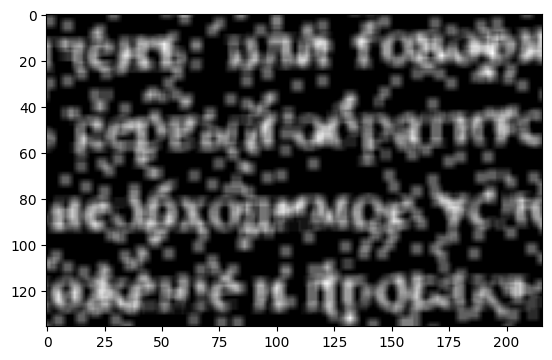

In [47]:
crc_filtred = sliding_window_mean(crc, w_size)
print(crc_filtred.shape, crc.shape)
plt.imshow(crc_filtred, cmap='gray')

(136, 216) (140, 220)


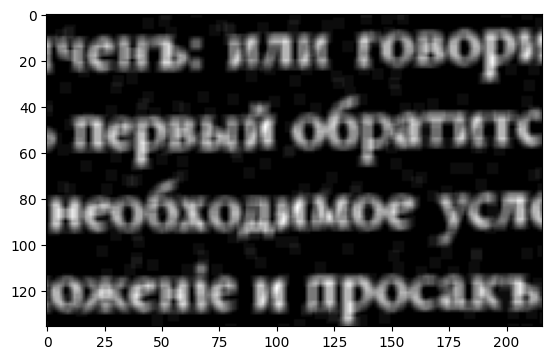

In [48]:
sp_filtred = sliding_window_mean(sp, w_size)
print(sp_filtred.shape, sp.shape)
plt.imshow(sp_filtred, cmap='gray')

In [49]:
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2 - cropx//2
    starty = y//2 - cropy//2    
    return img[starty:starty+cropy, startx:startx+cropx]

In [53]:
t = 1
def sliding_window_circle(f, window_size, mean):
    h, w = f.shape
    r_h = (h - window_size[0] + 1)
    r_w = (w - window_size[1] + 1)
    print(r_h, r_w)
    result = crop_center(np.copy(f), r_w, r_h)
    print(result.shape)
    i, j = 0, 0
    for x in range(0, w-window_size[1]+1):
        j = 0
        for y in range(0, h - window_size[0] + 1):
            window_f = f[y:y+window_size[0], x:x+window_size[1]]
            pr = projection_circle(np.copy(window_f))
            a = np.linalg.norm((window_f - pr))**2/np.linalg.norm(pr - E(np.copy(window_f)))**2
            if a < t:
                result[j-1:j+2, i-1:i+2] = mean[j-1:j+2, i-1:i+2]
            j += 1
        i += 1
    return result  
    
def sliding_window_point(f, window_size, mean):
    h, w = f.shape
    r_h = (h - window_size[0] + 1)
    r_w = (w - window_size[1] + 1)
    print(r_h, r_w)
    result = crop_center(np.copy(f), r_w, r_h)
    print(result.shape)
    i, j = 0, 0
    for x in range(0, w-window_size[1]+1):
        j = 0
        for y in range(0, h - window_size[0] + 1):
            window_f = f[y:y+window_size[0], x:x+window_size[1]]
            pr = projection_point(np.copy(window_f))
            a = np.linalg.norm((window_f - pr))**2/np.linalg.norm(pr - E(np.copy(window_f)))**2
            if a < t:
                result[j, i] = mean[j, i]
            j += 1
        i += 1
    return result  

136 216
(136, 216)


/tmp/ipykernel_72687/1045217784.py:35: RuntimeWarning: invalid value encountered in scalar divide
  a = np.linalg.norm((window_f - pr))**2/np.linalg.norm(pr - E(np.copy(window_f)))**2


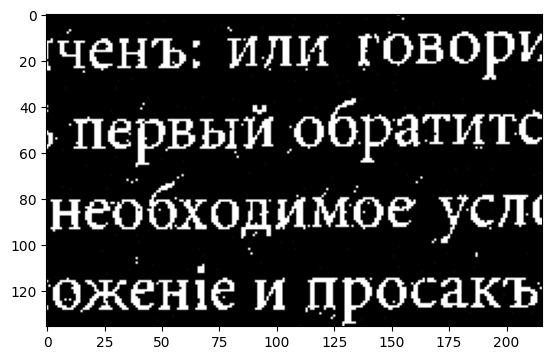

In [54]:
sp_morph_filtred = sliding_window_point(sp, w_size, sp_filtred)
plt.imshow(sp_morph_filtred, cmap='gray')

136 216
(136, 216)


/tmp/ipykernel_72687/1045217784.py:15: RuntimeWarning: invalid value encountered in scalar divide
  a = np.linalg.norm((window_f - pr))**2/np.linalg.norm(pr - E(np.copy(window_f)))**2


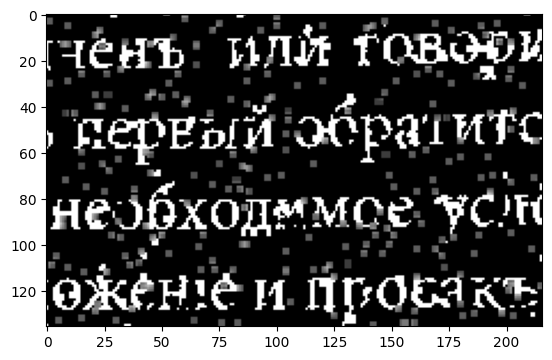

In [55]:
crc_morph_filtred = sliding_window_circle(crc, w_size, crc_filtred)
plt.imshow(crc_morph_filtred, cmap='gray')